# TP : Algorithmes Génétiques pour la Détection de Bords avec PyGAD

Dans ce TP, nous implémenterons un algorithme génétique (GA) en Python pour concevoir automatiquement un **filtre convolutif de détection de bords**. L'objectif est d'approximer un filtre connu (ici, le filtre **Sobel**) en utilisant la bibliothèque d'algorithmes génétiques [PyGAD](https://pygad.readthedocs.io).

### Objectifs du TP :

- Concevoir un chromosome représentant un filtre convolutif.
- Définir une fonction d'évaluation mesurant la qualité d'un filtre par rapport au filtre de référence (Sobel).
- Configurer et exécuter l'algorithme génétique pour évoluer progressivement vers un filtre optimal.

> **Rappel :** Un **algorithme génétique** repose sur une analogie avec l'évolution biologique. Une population d'individus (solutions) est évaluée par une fonction dite de **fitness**. À chaque génération, on sélectionne les meilleurs individus pour former de nouveaux individus par **croisement** et **mutation**, permettant ainsi une exploration efficace de l'espace de solutions.


## Technologies et Bibliothèques utilisées

- **PyGAD** :  
  Bibliothèque Python facilitant l'implémentation d'algorithmes génétiques avec une interface simple et intuitive. PyGAD permet une personnalisation complète des opérateurs génétiques (sélection, croisement, mutation).

- **OpenCV (cv2)** :  
  Bibliothèque largement utilisée en vision par ordinateur pour la manipulation et le traitement d'images. Elle est notamment utilisée ici pour les convolutions et le filtrage.

- **Matplotlib** :  
  Bibliothèque pour la visualisation des résultats intermédiaires et finaux directement dans le notebook Jupyter.

Ces outils sont combinés pour démontrer la puissance des algorithmes évolutionnaires dans l'optimisation automatique des filtres de traitement d'image.


In [1]:
%pip install pygad opencv-python-headless matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports et Fonctions Utilitaires

Nous allons commencer par importer les bibliothèques nécessaires et définir les fonctions utilitaires.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pygad import pygad

# Mode batch pour exécution non-interactive (Papermill/MCP)
import os
BATCH_MODE = os.getenv("BATCH_MODE", "false").lower() in ("true", "1", "yes")
if BATCH_MODE:
    plt.ioff()  # Désactive le mode interactif matplotlib

# Fonction pour sauvegarder une image
def save_image(image, filename):
    cv2.imwrite(filename, image)
    print(f"Image enregistrée : {filename}")

# Fonction pour convertir une image Bitmap en Matrice OpenCV
def bitmap_to_mat(bitmap):
    return cv2.cvtColor(np.array(bitmap), cv2.COLOR_BGR2RGB)

# Fonction pour afficher une image
def display_image(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.close()  # Ferme la figure pour éviter blocage en mode batch

## Définition du Chromosome (EdgeChromosome)

Dans cette implémentation, chaque chromosome représente un filtre de convolution complet. Il est composé d'un ensemble de **gènes**, chacun étant une matrice 7x7 de coefficients. Le filtre final appliqué à l'image correspond à la somme de toutes ces matrices de gènes.

### Pourquoi utiliser cette approche ?

- **Évolution progressive** : Chaque gène apporte une contribution partielle au filtre complet, permettant à l'algorithme d'explorer graduellement des solutions.
- **Exploration efficace** : La mutation et le croisement agissent sur des sous-unités indépendantes, augmentant la diversité et facilitant l'optimisation.

Ci-dessous, nous définissons la classe Python correspondant à cette représentation.


In [3]:
class EdgeChromosome:
    def __init__(self, length):
        self.kernel_size = 7  # Définir kernel_size avant de l'utiliser dans generate_gene
        self.length = length
        self.genes = [self.generate_gene() for _ in range(length)]

    def generate_gene(self):
        return np.random.randint(-20, 20, (self.kernel_size, self.kernel_size), dtype=np.int64)

    def get_complete_matrix(self):
        complete_matrix = np.zeros((self.kernel_size, self.kernel_size), dtype=np.float32)
        for gene in self.genes:
            complete_matrix += gene.astype(np.float32)
        
        max_abs = np.max(np.abs(complete_matrix))
        if max_abs > 10:
            complete_matrix = 10.0 * complete_matrix / max_abs
        return complete_matrix
    

## Vérification du Chromosome créé

Testons maintenant la création d'un chromosome afin de vérifier que les gènes et la matrice résultante sont générés correctement.

**Attendu :** Une série de matrices 7x7 suivie d'une matrice résultante (somme normalisée).


In [4]:
test_chromosome = EdgeChromosome(5)
print("Gènes générés :")
for gene in test_chromosome.genes:
    print(gene)
    print()

test_matrix = test_chromosome.get_complete_matrix()
print("Matrice complète générée :")
print(test_matrix)

Gènes générés :
[[ 15  19   9  -9  -2  -9  -9]
 [-18   1  -6 -19  -2  -9 -20]
 [ 10   0   4  -4 -16   5  18]
 [ -2  10 -15  -4   6  11  14]
 [ -9  -8   7  15  -7 -10 -15]
 [ -3  -3  -8 -12 -10  -9  -4]
 [ 18 -18  -1 -17 -14  -1  -5]]

[[-19  10  19 -19  10  -3  18]
 [  5  17   9  -8   0   1  12]
 [ 10   6 -12  -4 -20 -14 -15]
 [  3  11  -5  18  -2   0 -15]
 [-11  -8 -16  10  14  -1 -17]
 [-18  19  18  -9 -10 -20  13]
 [-14 -19 -15  16 -19   1  17]]

[[-11   6   3  -5   1   5  19]
 [ -3  14  -7   0  18  -6  11]
 [  4  11  14  19   8  11  -7]
 [ 19   0 -14 -11 -13   5 -14]
 [ -5  10  10  14  16  -6  18]
 [  5  18  18 -15   1  19   5]
 [  2  14  19  -4  -7  -3 -16]]

[[-20  13  -1  14  16 -20  -4]
 [-18 -13   2   2  -6  -7 -15]
 [ 16   3  -5 -16  14  16   9]
 [-16   8  11  14  -6  12 -14]
 [-19 -11  16  10 -10  12  -5]
 [ 11  10  17 -20  15   8 -14]
 [ -9  13 -11   5   4  -8   6]]

[[-10 -19 -12 -10  15  15 -12]
 [  1   1 -10  -7  14 -11  10]
 [ 19  -6   7   4  -5  11   9]
 [ 16  17 -14  

## Fonction d'Évaluation (Fitness)

La **fonction d'évaluation** mesure la performance d'un filtre (chromosome) en comparant l'image obtenue par convolution avec l'image originale filtrée par le filtre Sobel (référence).  

### Étapes de l'évaluation :

1. **Filtrage convolutif** :  
   Le filtre généré par le chromosome est appliqué à l'image originale.

2. **Comparaison avec le filtre Sobel** :  
   L'image obtenue est comparée avec l'image de référence obtenue par le filtre Sobel, en utilisant une mesure de similarité (corrélation normalisée).

3. **Pénalisation des filtres uniformes** :  
   Pour éviter les solutions uniformes (avec des coefficients très faibles), une pénalité basée sur la somme absolue des coefficients du filtre est appliquée.

Cette approche permet de guider l'évolution vers des filtres capables de détecter efficacement les contours dans l'image.


In [5]:
import cv2
import numpy as np
import math

class EdgeFitness:
    def __init__(self, original_image):
        """
        Calcule l'image de référence via la magnitude du Sobel en X et Y, 
        normalisée dans la plage [0, 255].
        """
        # Conversion en niveaux de gris (8 bits)
        gray = cv2.cvtColor(np.array(original_image), cv2.COLOR_BGR2GRAY)

        # Sobel en X et Y
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # Magnitude = sqrt(SobelX^2 + SobelY^2)
        magnitude = np.sqrt(sobelx**2 + sobely**2)

        # Normalisation manuelle dans [0, 255]
        if magnitude.max() > 0:
            magnitude = (magnitude / magnitude.max()) * 255.0
        magnitude = magnitude.astype(np.uint8)

        self.reference_image = magnitude
        self.original_gray = gray  # on conserve l'image 8 bits en nuances de gris

    def display_images(self):
        """
        Affiche l'image d'origine (gris) et l'image Sobel de référence.
        """
        # Image originale
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.imshow(self.original_gray, cmap='gray')
        plt.title("Original Gray")
        plt.axis('off')

        # Image Sobel
        plt.subplot(1,2,2)
        plt.imshow(self.reference_image, cmap='gray')
        plt.title("Sobel Reference")
        plt.axis('off')
        plt.show()
        plt.close()  # Ferme la figure pour éviter blocage en mode batch

    def apply_filter(self, chromosome, display=False):
        """
        Construit la matrice complète du chromosome et l'applique sur l'image originale via cv2.filter2D.
        Retourne le résultat normalisé en [0,255].
        """
        # Reconstruction du noyau en float32
        filter_matrix = chromosome.get_complete_matrix()
        if display:
            print("Noyau généré :\n", filter_matrix)

        # Appliquer la convolution avec un borderType par défaut
        filtered_float = cv2.filter2D(self.original_gray.astype(np.float32), ddepth=-1, kernel=filter_matrix, borderType=cv2.BORDER_DEFAULT)

        # Conversion en uint8 sans normalisation excessive
        filtered_uint8 = cv2.convertScaleAbs(filtered_float)
        return filtered_uint8


    def evaluate(self, solution, solution_idx):
        """
        Transforme le 'solution' en chromosome, applique le filtre, 
        puis compare avec l'image Sobel de référence via la corrélation normalisée.
        Applique la pénalisation sur la somme des coefficients.
        """
        # Reconstruire le chromosome depuis le vecteur 'solution'
        from math import log10

        # On suppose 20 gènes de 7x7 = 49 coeff par gène
        gene_count = 20
        gene_size = 49
        chromosome = EdgeChromosome(gene_count)
        for i in range(gene_count):
            start = i*gene_size
            end   = start + gene_size
            arr   = np.array(solution[start:end]).reshape(7,7).astype(np.int64)
            chromosome.genes[i] = arr

        # Filtrage
        filtered_img = self.apply_filter(chromosome, display=False)

        # Vérifier la taille/dtype vs reference
        if filtered_img.shape != self.reference_image.shape:
            filtered_img = cv2.resize(filtered_img, 
                                      (self.reference_image.shape[1], 
                                       self.reference_image.shape[0]))

        # Corrélation normalisée
        result = cv2.matchTemplate(filtered_img, self.reference_image, cv2.TM_CCORR_NORMED)
        _, maxVal, _, _ = cv2.minMaxLoc(result)

        # Calcul de la pénalisation identique à GeneticSharp 
        # (log10(|sumCoeffs| + 1))
        full_matrix = chromosome.get_complete_matrix()
        filter_sum = np.sum(full_matrix)
        filter_penalty = 1.0
        if abs(filter_sum) >= 1e-3:
            filter_penalty = log10(abs(filter_sum) + 1.0)

        # Score final
        # multiplier éventuellement par 1000 pour avoir un range plus large
        score = (maxVal * 1000.0) / filter_penalty

        return score

    def display_chromosome_result(self, chromosome, filename_prefix, generation):
        """
        Affiche ou sauvegarde l'image filtrée (optionnel).
        """
        filtered_img = self.apply_filter(chromosome, display=True)
        filename = f"{filename_prefix}_generation_{generation}.png"

        cv2.imwrite(filename, filtered_img)
        print(f"Image enregistrée : {filename}")

        plt.figure()
        plt.imshow(filtered_img, cmap='gray')
        plt.title(f"Generation {generation}")
        plt.axis('off')
        plt.show()
        plt.close()  # Ferme la figure pour éviter blocage en mode batch

### Test de la Fonction Fitness

Test de la fonction fitness.

In [6]:
from PIL import Image
# Test de la fonction fitness
image_path = r"MRI_Prostate_Cancer.jpg"
original_image = Image.open(image_path)
fitness = EdgeFitness(original_image)

# Test d'un chromosome
chromosome = EdgeChromosome(20)
print(f"Score de fitness : {fitness.evaluate(np.concatenate([gene.flatten() for gene in chromosome.genes]), 0)}")

Score de fitness : 552.5470703651549


## Configuration de l'Algorithme Génétique avec PyGAD

Nous configurons l'algorithme génétique à l'aide des paramètres suivants :

- **Taille de la population :** Nombre total d'individus testés à chaque génération.
- **Sélection :** Stratégie pour choisir les parents les mieux adaptés (`"sss"` : steady-state selection).
- **Croisement :** Combinaison des gènes des parents pour créer des enfants (`"uniform"` : croisement uniforme).
- **Mutation :** Modifications aléatoires pour introduire de nouvelles variations (`"random"` avec 10 % de gènes mutés à chaque génération).
- **Critère d'arrêt :** Nombre fixé de générations (ici, 100 générations).

Ces choix influencent directement la qualité et la rapidité de la convergence vers une solution optimale.


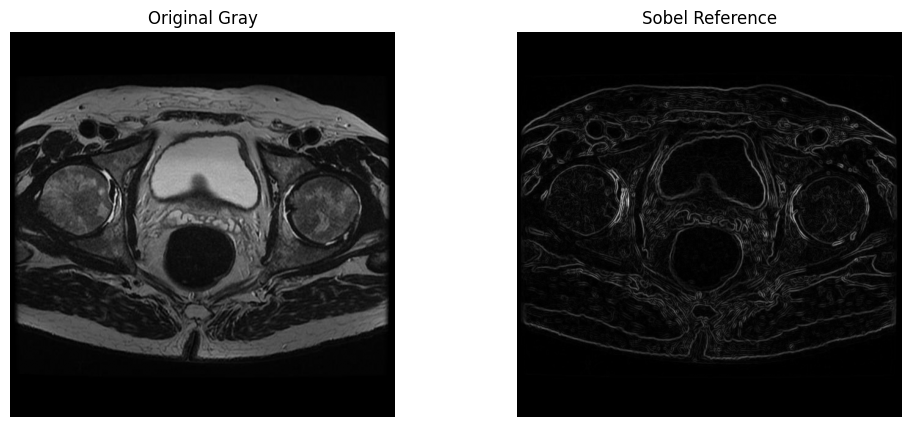

In [7]:
# -------------------------------------------------------------------
# A) Charger l'image avec PIL ou cv2, puis créer l'objet Fitness
# -------------------------------------------------------------------

image_path = r"MRI_Prostate_Cancer.jpg"  # Remplacez par le chemin de votre image

original_image = Image.open(image_path)

# Créer notre objet fitness
fitness_object = EdgeFitness(original_image)
fitness_object.display_images()  # Pour vérifier l'image de référence Sobel

# -------------------------------------------------------------------
# B) Définir la fonction de fitness pour PyGAD
# -------------------------------------------------------------------
def fitness_func(ga_instance, solution, solution_idx):
    return fitness_object.evaluate(solution, solution_idx)

# -------------------------------------------------------------------
# C) Callback pour la visualisation à chaque génération
# -------------------------------------------------------------------
def on_generation(ga_instance):
    best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
    print(f"Génération {ga_instance.generations_completed} - Meilleur score : {best_solution_fitness}")

    # Affiche l'image tous les 10 tours
    if ga_instance.generations_completed % 10 == 0:
        # Reconstruire le chromosome
        gene_count = 20
        gene_size  = 49
        best_chromosome = EdgeChromosome(gene_count)
        for i in range(gene_count):
            start = i*gene_size
            end   = start + gene_size
            arr   = np.array(best_solution[start:end]).reshape(7,7).astype(np.int64)
            best_chromosome.genes[i] = arr

        fitness_object.display_chromosome_result(best_chromosome, "best", ga_instance.generations_completed)

# -------------------------------------------------------------------
# D) Configurer et lancer le GA
#    - 20 gènes, chaque gène = 7x7 = 49 coefficients
#    - On veut donc un chromosome de 20*49 = 980 coefficients
# -------------------------------------------------------------------
import pygad

chromosome_length = 20 * 49  # 980
population_size  = (100, chromosome_length)  # Ex.: 100 individus

ga_instance = pygad.GA(
    num_generations = 100,
    num_parents_mating = 10,
    fitness_func = fitness_func,
    sol_per_pop = population_size[0],
    num_genes = population_size[1],
    init_range_low = -20,
    init_range_high = 20,
    parent_selection_type = "sss",
    keep_parents = -1,
    crossover_type = "uniform",
    mutation_type = "random",
    mutation_percent_genes = 10,
    on_generation = on_generation
)


## Exécution de l'Algorithme et Visualisation des Résultats

Lors de l'exécution de l'algorithme génétique, nous visualisons régulièrement :

- **L'évolution du meilleur score** à chaque génération, indiquant comment l'algorithme progresse.
- **Les images filtrées intermédiaires** obtenues toutes les 10 générations pour suivre visuellement l'amélioration du filtre.

Cela permet une compréhension intuitive du comportement de l'algorithme et de sa capacité à améliorer progressivement la solution.


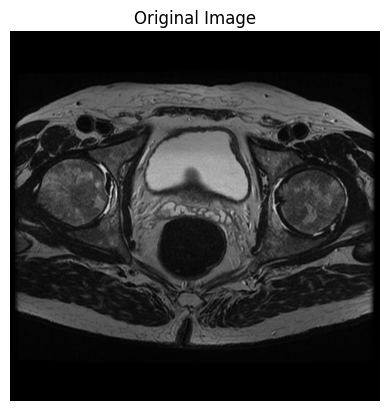

Génération 1 - Meilleur score : 23207.734944436976


Génération 2 - Meilleur score : 23207.734944436976


Génération 3 - Meilleur score : 23207.734944436976


Génération 4 - Meilleur score : 23207.734944436976


Génération 5 - Meilleur score : 23207.734944436976


Génération 6 - Meilleur score : 23207.734944436976


Génération 7 - Meilleur score : 23207.734944436976


Génération 8 - Meilleur score : 23207.734944436976


Génération 9 - Meilleur score : 23207.734944436976


Génération 10 - Meilleur score : 23207.734944436976
Noyau généré :
 [[ 3.4615386  -2.3076923   3.2307692  -4.6923075  -4.1538463   1.3076923
   3.8461537 ]
 [ 4.1538463   1.6153846  -3.1538463   1.5384616   0.3846154  -0.9230769
   6.        ]
 [ 4.4615383   6.769231   -1.5384616  -3.3076923  -1.4615384   0.6923077
  -3.8461537 ]
 [-5.8461537   2.3076923   1.3076923  -1.1538461   4.230769    2.7692308
   0.53846157]
 [-0.23076923  0.61538464  4.769231   -6.076923    0.3846154  -8.538462
  -2.3846154 ]
 [ 1.0769231   3.7692308  -3.0769231  -4.1538463  -0.07692308  1.9230769
  -4.076923  ]
 [-2.6923077  -1.7692307   1.0769231  10.         -1.2307693  -2.7692308
  -2.6923077 ]]
Image enregistrée : best_generation_10.png


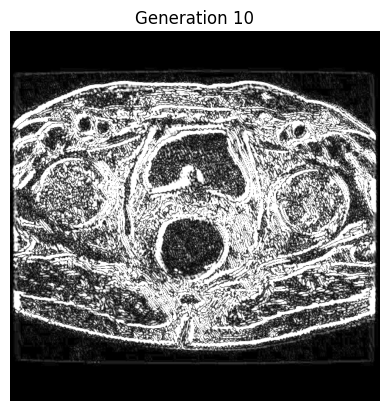

Génération 11 - Meilleur score : 23207.734944436976


Génération 12 - Meilleur score : 23207.734944436976


Génération 13 - Meilleur score : 23207.734944436976


Génération 14 - Meilleur score : 29843.77133917182


Génération 15 - Meilleur score : 29843.77133917182


Génération 16 - Meilleur score : 29843.77133917182


Génération 17 - Meilleur score : 29843.77133917182


Génération 18 - Meilleur score : 29843.77133917182


Génération 19 - Meilleur score : 29843.77133917182


Génération 20 - Meilleur score : 29843.77133917182
Noyau généré :
 [[  1.9277109   -0.5421687    3.313253    -3.1927712   -4.2771087
    2.1686747   -0.6626506 ]
 [  1.9277109    2.8313253   -2.2891567    1.686747     1.9277109
   -1.5662651    3.1927712 ]
 [  1.0240964    3.253012    -2.4698796    1.626506     2.9518073
    2.6506023   -0.90361446]
 [ -3.7951808    2.5903614   -2.1686747   -2.8313253    0.36144578
    1.2650602    0.5421687 ]
 [  2.3493977    1.5060241    3.8554218   -0.18072289  -0.06024097
  -10.          -0.12048193]
 [  1.4457831    0.8433735   -4.0361447   -3.7951808    1.626506
    0.96385545  -4.879518  ]
 [ -3.313253     0.12048193   1.9277109    7.1084337   -0.24096386
   -0.06024097  -5.5421686 ]]
Image enregistrée : best_generation_20.png


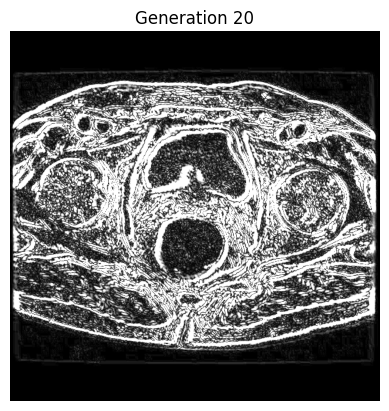

Génération 21 - Meilleur score : 29843.77133917182


Génération 22 - Meilleur score : 29843.77133917182


Génération 23 - Meilleur score : 29843.77133917182


Génération 24 - Meilleur score : 29843.77133917182


Génération 25 - Meilleur score : 30023.89987599738


Génération 26 - Meilleur score : 30023.89987599738


Génération 27 - Meilleur score : 30134.82597164688


Génération 28 - Meilleur score : 30134.82597164688


Génération 29 - Meilleur score : 30471.58304314169


Génération 30 - Meilleur score : 30471.58304314169
Noyau généré :
 [[  1.9526627   -0.295858     3.1360946   -3.1952662   -5.6804733
    2.2485206   -0.591716  ]
 [  2.3076923    2.7218935   -1.9526627    1.6568047    2.1893492
   -1.4201183    2.485207  ]
 [  1.0059172    4.260355    -2.1301775    1.3017751    1.3017751
    2.7218935   -0.591716  ]
 [ -4.3195267    2.6035502   -2.0710058   -2.7218935    0.295858
    1.5384616    0.71005917]
 [  2.1893492    1.4792899    3.7869823    0.4733728   -0.41420117
  -10.           1.8343195 ]
 [  1.2426035    1.4201183   -4.260355    -3.7869823    1.5384616
    0.591716    -4.733728  ]
 [ -3.4319527    0.           1.8934911    6.745562    -0.4733728
   -0.0591716   -5.56213   ]]
Image enregistrée : best_generation_30.png


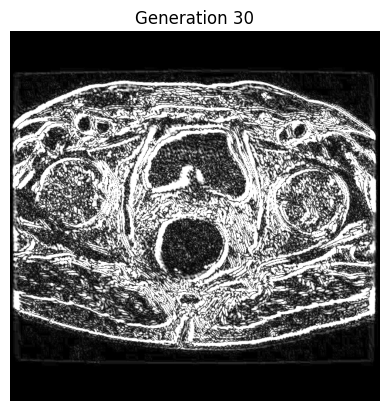

Génération 31 - Meilleur score : 30471.58304314169


Génération 32 - Meilleur score : 30640.925986322392


Génération 33 - Meilleur score : 30652.966753064364


Génération 34 - Meilleur score : 30720.998923891402


Génération 35 - Meilleur score : 30720.998923891402


Génération 36 - Meilleur score : 31061.10065480193


Génération 37 - Meilleur score : 32006.31593015448


Génération 38 - Meilleur score : 32024.33863589284


Génération 39 - Meilleur score : 32024.33863589284


Génération 40 - Meilleur score : 32137.76923695353
Noyau généré :
 [[  2.1348314   -0.33707866   3.3707864   -2.752809    -5.674157
    2.247191    -0.28089887]
 [  1.9101124    2.8089888   -1.9101124    1.5168539    1.7977529
   -1.4606742    2.4157302 ]
 [  1.2921349    4.101124    -2.022472     1.4606742    1.2921349
    2.5842698   -0.6179775 ]
 [ -4.101124     2.52809     -1.7977529   -2.977528     0.4494382
    1.3483146    0.6179775 ]
 [  1.9101124    1.235955     3.6516855    0.505618    -0.56179774
  -10.           1.4606742 ]
 [  1.1235955    0.56179774  -3.9325843   -3.8202248    1.3483146
    0.505618    -4.4382024 ]
 [ -2.3595505    0.39325842   1.741573     6.4044943   -0.28089887
    0.          -5.3370786 ]]
Image enregistrée : best_generation_40.png


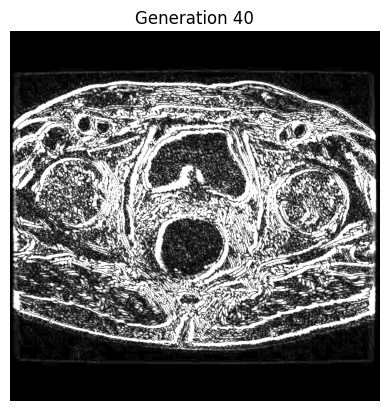

Génération 41 - Meilleur score : 32312.49876311588


Génération 42 - Meilleur score : 32351.59993699385


Génération 43 - Meilleur score : 32351.59993699385


Génération 44 - Meilleur score : 32351.59993699385


Génération 45 - Meilleur score : 32725.702951539417


Génération 46 - Meilleur score : 32725.702951539417


Génération 47 - Meilleur score : 32917.49836537791


Génération 48 - Meilleur score : 32917.49836537791


Génération 49 - Meilleur score : 33007.24498968932


Génération 50 - Meilleur score : 33428.350136864094
Noyau généré :
 [[  2.054054    -0.43243244   3.0810812   -2.9189188   -5.4594593
    2.108108    -0.43243244]
 [  1.945946     2.4864864   -2.108108     1.6756756    2.054054
   -1.2972972    2.3243244 ]
 [  1.3513514    3.7837837   -2.108108     1.2432432    1.081081
    2.5945945   -0.4864865 ]
 [ -4.4864864    2.3783784   -2.2702703   -2.4864864    0.3243243
    1.2432432    0.5945946 ]
 [  1.8918918    1.4054054    3.5135136    0.43243244  -0.3243243
  -10.           1.6756756 ]
 [  1.027027     0.7567568   -3.6756756   -3.6216216    1.5135136
    0.7027027   -4.        ]
 [ -2.           0.21621622   1.945946     6.4324327   -0.4864865
   -0.21621622  -4.972973  ]]
Image enregistrée : best_generation_50.png


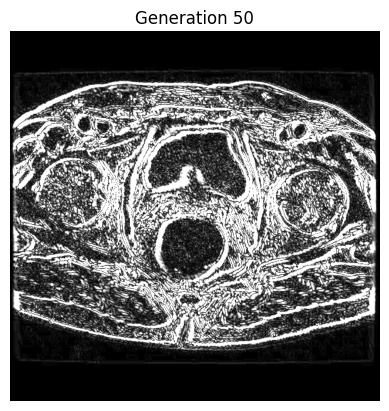

Génération 51 - Meilleur score : 33428.350136864094


Génération 52 - Meilleur score : 33445.92967014078


Génération 53 - Meilleur score : 33593.94949510314


Génération 54 - Meilleur score : 33951.2983811694


Génération 55 - Meilleur score : 33951.2983811694


Génération 56 - Meilleur score : 34012.37170180495


Génération 57 - Meilleur score : 34012.37170180495


Génération 58 - Meilleur score : 34367.222460745616


Génération 59 - Meilleur score : 34367.222460745616


Génération 60 - Meilleur score : 34367.222460745616
Noyau généré :
 [[  2.0526316   -0.42105263   3.          -2.7894738   -5.5263157
    2.2105262   -0.6315789 ]
 [  2.2105262    2.5263157   -1.8947369    1.5263158    2.
   -1.2631578    2.1052632 ]
 [  1.3157895    3.631579    -2.1578948    1.4210526    1.
    2.3157895   -0.21052632]
 [ -4.368421     2.368421    -2.1052632   -2.368421     0.31578946
    0.8947368    0.5263158 ]
 [  2.2105262    1.3157895    3.3157895    0.           0.
  -10.           1.5263158 ]
 [  1.1052631    0.42105263  -3.5263157   -3.631579     1.2631578
    0.5263158   -3.5789473 ]
 [ -2.           0.2631579    2.1052632    6.2105265   -0.5263158
   -0.05263158  -4.6842103 ]]
Image enregistrée : best_generation_60.png


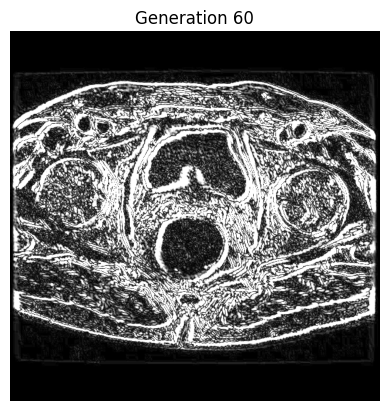

Génération 61 - Meilleur score : 34505.69766126403


Génération 62 - Meilleur score : 34505.69766126403


Génération 63 - Meilleur score : 34782.37103712772


Génération 64 - Meilleur score : 35172.852409968444


Génération 65 - Meilleur score : 35172.852409968444


Génération 66 - Meilleur score : 35172.852409968444


Génération 67 - Meilleur score : 35172.852409968444


Génération 68 - Meilleur score : 35378.20924920111


Génération 69 - Meilleur score : 35383.31172739459


Génération 70 - Meilleur score : 35383.31172739459
Noyau généré :
 [[  1.7435898   -0.35897437   3.0769231   -2.4615386   -5.282051
    2.0512822   -0.51282054]
 [  2.2051282    2.2051282   -1.948718     1.5897436    2.
   -1.4358975    2.0512822 ]
 [  1.3846154    3.5384614   -1.8974359    1.1282052    0.974359
    2.2564104   -0.25641027]
 [ -4.205128     2.6153846   -1.8461539   -2.3076923    0.20512821
    0.5641026    0.51282054]
 [  2.           1.1282052    3.3333333    0.51282054  -0.46153846
  -10.           1.3846154 ]
 [  0.82051283   0.7692308   -3.4358974   -3.2820513    1.4871795
    0.71794873  -3.6923077 ]
 [ -2.102564     0.05128205   1.948718     6.1025643   -0.30769232
    0.1025641   -4.6153846 ]]
Image enregistrée : best_generation_70.png


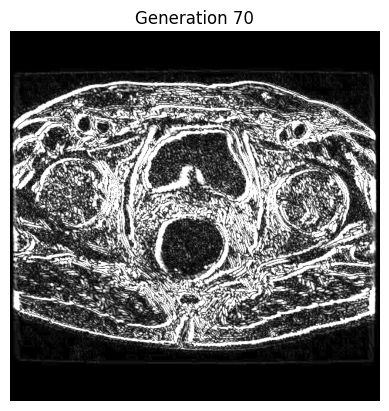

Génération 71 - Meilleur score : 35383.31172739459


Génération 72 - Meilleur score : 35383.66711648614


Génération 73 - Meilleur score : 35792.292530712875


Génération 74 - Meilleur score : 35792.292530712875


Génération 75 - Meilleur score : 35792.292530712875


Génération 76 - Meilleur score : 35793.967520015


Génération 77 - Meilleur score : 35793.967520015


Génération 78 - Meilleur score : 35983.21645197541


Génération 79 - Meilleur score : 36026.33814659039


Génération 80 - Meilleur score : 36026.33814659039
Noyau généré :
 [[  1.7676767   -0.3030303    3.3333333   -2.4242425   -5.20202
    1.7676767   -0.25252524]
 [  2.020202     2.4747474   -1.7171717    1.4646465    2.121212
   -1.3636364    2.070707  ]
 [  1.5151515    3.1818182   -1.8181819    1.1616162    1.1616162
    2.3232324   -0.6060606 ]
 [ -4.3434343    2.5252526   -1.6666666   -2.3737373    0.25252524
    0.75757575   0.45454547]
 [  1.8686869    0.90909094   3.4343433    0.6060606   -0.6060606
  -10.           1.6666666 ]
 [  0.8080808    0.90909094  -3.3333333   -3.3333333    1.3131313
    0.45454547  -3.5353534 ]
 [ -2.2222223    0.1010101    1.6161616    5.959596    -0.45454547
   -0.15151516  -4.3434343 ]]
Image enregistrée : best_generation_80.png


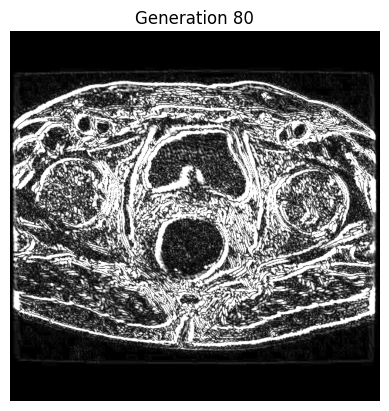

Génération 81 - Meilleur score : 36197.28586087898


Génération 82 - Meilleur score : 36197.28586087898


Génération 83 - Meilleur score : 36240.40079338549


Génération 84 - Meilleur score : 36240.40079338549


Génération 85 - Meilleur score : 36247.19261277405


Génération 86 - Meilleur score : 36247.19261277405


Génération 87 - Meilleur score : 36247.28319464939


Génération 88 - Meilleur score : 36263.58590374471


Génération 89 - Meilleur score : 36526.780291305426


Génération 90 - Meilleur score : 36987.9306041182
Noyau généré :
 [[  1.8719212   -0.3448276    3.0541873   -2.5123153   -5.0738916
    1.9211823   -0.19704433]
 [  2.0689654    2.364532    -1.6748768    1.3793104    2.2167487
   -1.4778326    2.0197043 ]
 [  1.5763546    3.546798    -2.1182265    1.4285715    0.6896552
    1.9211823   -0.5418719 ]
 [ -4.137931     2.7586207   -1.4285715   -1.9704434    0.09852216
    0.8374384    0.39408866]
 [  1.9211823    0.8866995    3.3497536    0.49261084  -0.591133
  -10.           1.6256157 ]
 [  0.39408866   0.6403941   -3.3004925   -3.2512314    1.3300493
    0.39408866  -3.3990147 ]
 [ -2.1182265    0.19704433   1.6256157    5.9605913   -0.44334975
   -0.04926108  -4.285714  ]]
Image enregistrée : best_generation_90.png


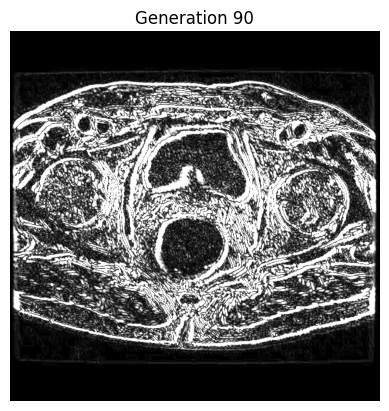

Génération 91 - Meilleur score : 36987.9306041182


Génération 92 - Meilleur score : 37159.43381044951


Génération 93 - Meilleur score : 37233.30622587337


Génération 94 - Meilleur score : 37354.67382354084


Génération 95 - Meilleur score : 37696.925036425804


Génération 96 - Meilleur score : 37791.330315245395


Génération 97 - Meilleur score : 37791.330315245395


Génération 98 - Meilleur score : 37958.40846500386


Génération 99 - Meilleur score : 37958.40846500386


Génération 100 - Meilleur score : 38007.36036623169
Noyau généré :
 [[  1.7307693   -0.5769231    2.9807692   -2.4038463   -4.7596154
    1.7307693   -0.28846154]
 [  2.0192308    2.5         -1.7307693    1.3461539    2.3076923
   -1.4423077    1.8269231 ]
 [  1.4903846    3.4134614   -1.9711539    1.25         0.91346157
    1.6346154   -0.1923077 ]
 [ -3.9903846    2.5480769   -1.4423077   -2.0192308   -0.09615385
    0.625        0.625     ]
 [  1.7788461    0.625        3.0769231    0.625       -0.48076922
  -10.           1.5865384 ]
 [  0.52884614   0.86538464  -3.2692308   -3.2211537    1.2980769
    0.52884614  -3.125     ]
 [ -2.3076923    0.52884614   1.4903846    6.0576925   -0.625
    0.14423077  -4.1826925 ]]
Image enregistrée : best_generation_100.png


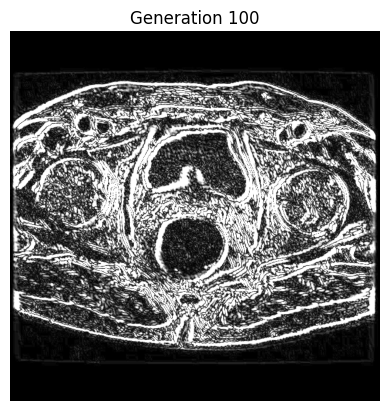

Noyau généré :
 [[  1.7307693   -0.5769231    2.9807692   -2.4038463   -4.7596154
    1.7307693   -0.28846154]
 [  2.0192308    2.5         -1.7307693    1.3461539    2.3076923
   -1.4423077    1.8269231 ]
 [  1.4903846    3.4134614   -1.9711539    1.25         0.91346157
    1.6346154   -0.1923077 ]
 [ -3.9903846    2.5480769   -1.4423077   -2.0192308   -0.09615385
    0.625        0.625     ]
 [  1.7788461    0.625        3.0769231    0.625       -0.48076922
  -10.           1.5865384 ]
 [  0.52884614   0.86538464  -3.2692308   -3.2211537    1.2980769
    0.52884614  -3.125     ]
 [ -2.3076923    0.52884614   1.4903846    6.0576925   -0.625
    0.14423077  -4.1826925 ]]
Image enregistrée : best_generation_100.png


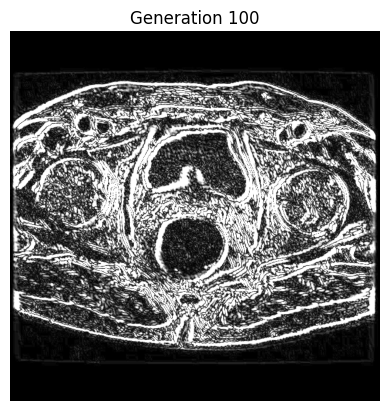

Meilleure solution trouvée avec un score de 38007.36036623169.


In [8]:
# Initialiser le placeholder avec l'image originale
display_image(bitmap_to_mat(original_image), "Original Image")

ga_instance.run()

best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
best_chromosome = EdgeChromosome(20)
best_chromosome.genes = [np.array(best_solution[i:i+49]).reshape(7, 7).astype(np.int64) for i in range(0, len(best_solution), 49)]
fitness.display_chromosome_result(best_chromosome, "best", ga_instance.generations_completed)
print(f"Meilleure solution trouvée avec un score de {best_solution_fitness}.")

## Conclusion et Perspectives

Dans ce TP, nous avons montré comment les algorithmes génétiques peuvent automatiser l'optimisation de filtres convolutifs pour la détection de bords. Cette approche permet une optimisation efficace de problèmes complexes en traitement d'image, en tirant parti de l'évolution naturelle pour explorer l'espace des solutions.

### Améliorations et perspectives possibles :

- Expérimenter avec différentes configurations des opérateurs génétiques (sélection, croisement, mutation) pour améliorer encore les résultats.
- Appliquer cette méthode à d'autres types de filtres ou à des images issues de différents contextes (médicales, satellites, etc.).
- Comparer les performances obtenues avec PyGAD en Python à celles obtenues avec GeneticSharp en C# pour évaluer les avantages de chaque technologie.

Cette méthode pédagogique met en évidence le potentiel et la flexibilité des algorithmes évolutionnaires en intelligence artificielle appliquée.
